In [1]:
import sys
sys.path.append("/home/dictus/dmt/v2")
from neuro_dmt.library.users.hugo.validations import SimpleValidation

In [2]:
from dmt.model.interface import Interface
from neuro_dmt.library.users.hugo.adapters import PRESYNAPTIC, POSTSYNAPTIC
import pandas as pd
from seaborn import heatmap


def plot_pre_post_heatmap(label, df):
    
    # TODO: test and handle case when not all groups have same parameters
    def make_hashable(df, columnlabel):
        # currently assume all entries have the same keys
        dict_column = df[columnlabel]
        keys = dict_column[0].keys()
        cat_column_label = columnlabel + ": " + ", ".join(keys)
        column_values = [", ".join(str(v) for v in d.values()) for d in dict_column.values]
        return df.drop(columns=columnlabel).assign(**{cat_column_label: column_values}), cat_column_label

    df, pre_col = make_hashable(df, PRESYNAPTIC)
    df, post_col = make_hashable(df, POSTSYNAPTIC)
    df_matrix = df.pivot_table(index=pre_col, columns=post_col, values='mean')
    fig = heatmap(df_matrix)
    return fig


class SynapsesPerConnectionAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def synapses_per_connection(model, parameters):
            """
            get the number of synapses per connection from the model
            for the pathway defined be pre and post mtype
            
            Arguments:
                model: the model to get the data from
                pre_mtype: string, the presynaptic mtype
                post_mtype: string, the postsynaptic mtype
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        Arguments:
            parameters: dict with keys PRESYNAPTIC and POSTSYNAPTIC
                        and values which are each a set of parameters
                        for pre and postsynaptic cells
        """
        return model.synapses_per_connection(parameters)
    
    def measurements_parameters(self, model):
        mtypes = model.mtypes()
        return [{PRESYNAPTIC: pre, POSTSYNAPTIC: post} for pre in mtypes for post in mtypes]
    
        
    def plot(self, labels, results_dataframes):
        return plot_pre_post_heatmap(labels[0], results_dataframes[0])
    

In [3]:
import numpy as np

class DummyAdapter:
    
    def synapses_per_connection(self, params):
        return np.random.poisson(10, np.random.poisson(2000))
    
    def mtypes(self):
        return [{'mtype': letter} for letter in ['a', 'b', 'c', 'd', 'e', 'f']]

In [4]:
DummyAdapter().synapses_per_connection('')


array([10, 11,  8, ..., 10, 10,  7])

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:42: Warning: <__main__.SynapsesPerConnectionAnalysis object at 0x7f7404b96e80> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))
/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:205: UserWarning: model number 0, <__main__.DummyAdapter object at 0x7f7404b96c18> does not have label
  .format(i, model))


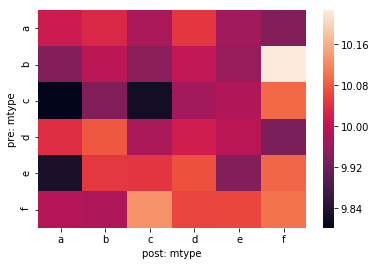

In [ ]:
SynapsesPerConnectionAnalysis()(DummyAdapter())

In [ ]:

class ConnectionProbabilityAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def connection_probability(model, parameters):
            """
            get the number of synapses per connection from the model
            for the pathway defined be pre and post mtype
            
            Arguments:
                model: the adapted model to extract data from
                parameters: dict with 'pre' and 'post' parameter sets
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        """
        return model.connection_probability(parameters)
    
    def measurements_parameters(self, model):
        """
        gets the available mtypes from the model
        effectively makes this a 'by mtype' validation
        """
        mtypes = model.mtypes()
        return [{'pre': pre, 'post': post} for pre in mtypes for post in mtypes]
    
        
    def plot(self, labels, results_dataframes):
        return plot_heatmap(labels[0], results_dataframes[0])

In [ ]:
from neuro_dmt.library.users.hugo.adapters import CircuitAdapter
ConnectionProbabilityAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:42: Warning: <__main__.ConnectionProbabilityAnalysis object at 0x7f73dc9d8a58> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))


None []


/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/adapters/__init__.py:217: Warning: old circuit with no atlas, cell_density method is unavailable
  Warning("old circuit with no atlas,"
/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:205: UserWarning: model number 0, <neuro_dmt.library.users.hugo.adapters.CircuitAdapter object at 0x7f73dc9d8ac8> does not have label
  .format(i, model))


{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer':

411
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L6', 'mtype': 'NBC'}
{'layer': [6], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1390
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L6', 'mtype': 'NGC'}
{'layer': [6], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
119
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L6', 'mtype': 'SBC'}
{'layer': [6], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
468
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L6', 'mtype': 'TPC_L1'}
{'layer': [6], 'mtype': ['L6_TPC_L1']}
11465


/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/adapters/__init__.py:96: Warning: Mtypes in queries to adapter should not be in form <layer>_<name>, but simply <name>recieved mtype TPC_L1
  "recieved mtype {}".format(mtype)))


{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L6', 'mtype': 'TPC_L4'}
{'layer': [6], 'mtype': ['L6_TPC_L4']}
10114


/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/adapters/__init__.py:96: Warning: Mtypes in queries to adapter should not be in form <layer>_<name>, but simply <name>recieved mtype TPC_L4
  "recieved mtype {}".format(mtype)))


{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L6', 'mtype': 'UTPC'}
{'layer': [6], 'mtype': ['L5_UTPC', 'L6_UTPC']}
12152
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L1', 'mtype'

{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L6', 'mtype': 'LBC'}
{'layer': [6], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3247
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L6', 'mtype': 'NBC'}
{'layer': [6], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1390
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L6', 'mtype': 'NGC'}
{'layer': [6], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
119
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L6', 'mtype': 'SBC'}
{'layer': [6], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
468
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L6', 'mtype': 'TPC_L1'}
{'layer'

{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L6', 'mtype': 'BP'}
{'layer': [6], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
488
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L6', 'mtype': 'BPC'}
{'layer': [6], 'mtype': ['L6_BPC']}
22255
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L6', 'mtype': 'BTC'}
{'layer': [6], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
381
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L6', 'mtype': 'ChC'}
{'layer': [6], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
112
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L6', 'mtype': 'DBC'}
{'layer': [6], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
216
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L6', 'mtype': 'IPC'}
{'layer': [6], 'mtype': ['L6_IPC']}
24253
{'layer': 'L1

500
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': 

{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC'

{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 

196
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC'

468
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L6', 'mtype': 'TPC_L1'}
{'layer': [6], 'mtype': ['L6_TPC_L1']}
11465
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L6', 'mtype': 'TPC_L4'}
{'layer': [6], 'mtype': ['L6_TPC_L4']}
10114
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L6', 'mtype': 'UTPC'}
{'layer': [6], 'mtype': ['L5_UTPC', 'L6_UTPC']}
12152
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer'

{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L5', 'mtype': 'TTPC2'}
{'layer': [5], 'mtype': ['L5_TTPC2']}
13987
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L5', 'mtype': 'UTPC'}
{'layer': [5], 'mtype': ['L5_UTPC', 'L6_UTPC']}
2403
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L6', 'mtype': 'BP'}
{'layer': [6], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
488
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L6', 'mtype': 'BPC'}
{'layer': [6], 'mtype': ['L6_BPC']}
22255
{'layer': ['L2',

{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L

{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC

{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L6', 'mtype': 'LBC'}
{'layer': [6], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3247
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L6', 'mtype': 'NBC'}
{'layer': [6], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1390
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L6', 'mtype': 'NGC'}
{'layer': [6], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
119
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L6',

{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L5', 

2320
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer

{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC',

112
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L6', 'mtype': 'DBC'}
{'layer': [6], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
216
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L6', 'mtype': 'IPC'}
{'layer': [6], 'mtype': ['L6_IPC']}
24253
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L6', 'mtype': 'LBC'}
{'layer': [6], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3247
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L6', 'mtype': 'NBC'}
{'layer':

238
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L5

{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{

{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L6', 'mtype': 'IPC'}
{'layer': [6], 'mtype': ['L6_IPC']}
24253
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L6', 'mtype': 'LBC'}
{'layer': [6], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3247
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L6', 'mtype': 'NBC'}
{'layer': [6], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1390
{'layer': ['L2', 'L3'], 'mtype': 'P

{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 

55
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_B

{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_D

{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L6', 'mtype': 'IPC'}
{'layer': [6], 'mtype': ['L6_IPC']}
24253
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L6', 'mtype': 'LBC'}
{'layer': [6], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3247
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L6', 'mtype': 'NBC'}
{'layer': [6], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1390
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L6', 'mtype': 'NGC'}
{'layer': [6], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
119
{

2784
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L4', 'mtype'

{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
273
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [

854
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L4',

{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L6', 'mtype': 'NGC'}
{'layer': [6], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
119
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L6', 'mtype': 'SBC'}
{'layer': [6], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
468
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L6', 'mtype': 'TPC_L1'}
{'layer': [6], 'mtype': ['L6_TPC_L1']}
11465
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L6', 'mtype': 'TPC_L4'}
{'layer': [6], 'mtype': ['L6_TPC_L4']}
10114
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L6', 'mtype': 'UTPC'}
{'layer': [6], 'mtype': ['L5_UTPC', 'L6_UTPC']}
12152
{'layer': 'L4', 'mtype': 'MC'}
{

{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L5', 'mtype': 'TTPC2'}
{'layer': [5], 'mtype': ['L5_TTPC2']}
13987
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L5', 'mtype': 'UTPC'}
{'layer': [5], 'mtype': ['L5_UTPC', 'L6_UTPC']}
2403
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L6', 'mtype': 'BP'}
{'layer': [6], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
488
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L6', 'mtype': 'BPC'}
{'layer': [6], 'mtype': ['L6_BPC']}
22255
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
82

{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L4', 'mtype': 'NBC'}
{'layer

{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': 'L4', 'm

{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': 'L6', 'mtype': 'UTPC'}
{'layer': [6], 'mtype': ['L5_UTPC', 'L6_UTPC']}
12152
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mt

{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', '

{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'LBC'}
{'layer': [4], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
854
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
431
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_

{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': ['L2', 'L3'], 'mtype': 'DBC'}
{'layer': [2, 3], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
1224
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'lay

{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
424
{'layer

{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L6', 'mtype': 'TPC_L1'}
{'layer': [6], 'mtype': ['L6_TPC_L1']}
11465
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L6', 'mtype': 'TPC_L4'}
{'layer': [6], 'mtype': ['L6_TPC_L4']}
10114
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L6', 'mtype': 'UTPC'}
{'layer': [6], 'mtype': ['L5_UTPC', 'L6_UTPC']}
12152
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L5', 'mtype': 'BP

{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L5', 'mtype': 'UTPC'}
{'layer': [5], 'mtype': ['L5_UTPC', 'L6_UTPC']}
2403
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L6', 'mtype': 'BP'}
{'layer': [6], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
488
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L6', 'mtype': 'BPC'}
{'layer': [6], 'mtype': ['L6_BPC']}
22255
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L6', 'mtype': 'BTC'}
{'layer': [6], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
381
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L6', 'mtype': 'ChC'}
{'layer': [6], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
112
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 

7687
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'

{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': 'L4', 'mtype':

{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L1', 'mtype': 'DLAC'}
{'layer': [1], 'mtype': ['L1_DLAC']}
167
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L1', 'mtype': 'HAC'}
{'layer': [1], 'mtype': ['L1_HAC']}
637
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer'

{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L6', 'mtype': 'BP'}
{'layer': [6], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
488
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L6', 'mtype': 'BPC'}
{'layer': [6], 'mtype': ['L6_BPC']}
22255
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L6', 'mtype': 'BTC'}
{'layer': [6], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
381
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L6', 'mtype': 'ChC'}
{'layer': [6], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
112
{'layer': 'L5', 'mtype': 'DBC'}
{'layer': [5], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
674
{'layer': 'L6', 'mtype': 'DBC'}
{'layer': [6], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
216
{'la

1464
{'layer': 'L4', 'mtype': 'SP'}
{'layer': [4], 'mtype': ['L4_SP']}
7687
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': 'L4', 'mtype': 'SS'}
{'layer': [4], 'mtype': ['L4_SS']}
2865
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': 'L5', 'mtype': 'BP'}
{'layer': [5], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
238
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': 'L5', 'mtype': 'BTC'}
{'layer': [5], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
527
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': 'L5', 'mtype': 'ChC'}
{'layer': [5], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
132
{'layer': 'L5', 'mtype': 'LBC'}
{'layer': [5], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
1464
{'layer': 'L5', 'mtype': 'DBC

41126
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': ['L2', 'L3'], 'mtype': 'SBC'}
{'layer': [2, 3], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
1163
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': 'L4', 'mtype': 'BP'}
{'layer': [4], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
55
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': 'L4', 'mtype': 'BTC'}
{'layer': [4], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
140
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': 'L4', 'mtype': 'ChC'}
{'layer': [4], 'mtype': ['L23_ChC', 'L4_ChC', 'L5_ChC', 'L6_ChC']}
56
{'layer': 'L5', 'mtype': 'MC'}
{'layer': [5], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2784
{'layer': 'L4', 'mtype': 'DBC'}
{'layer': [4], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_

{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L5', 'mtype': 'N

{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L6', 'mtype': 'DBC'}
{'layer': [6], 'mtype': ['L23_DBC', 'L4_DBC', 'L5_DBC', 'L6_DBC']}
216
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L6', 'mtype': 'IPC'}
{'layer': [6], 'mtype': ['L6_IPC']}
24253
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L6', 'mtype': 'LBC'}
{'layer': [6], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3247
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L6', 'mtype': 'MC'}
{'layer': [6], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2347
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L6', 'mtype': 'NBC'}
{'layer': [6], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1

{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L5', 'mtype': 'NBC'}
{'layer': [5], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1411
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': 'L5', 'mtype': 'NGC'}
{'layer': [5], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
56
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L5', 'mtype': 'NG

{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'MC'}
{'layer': [4], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
820
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'NBC'}
{'layer': [4], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
668
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'NGC'}
{'layer': [4], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
42
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'PC'}
{'layer': [4], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
18750
{'layer': 'L5', 'mtype': 'SBC'}
{'layer': [5], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
173
{'layer': 'L4', 'mtype': 'SBC'}
{'layer': [4], 

{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': ['L2', 'L3'], 'mtype': 'LBC'}
{'layer': [2, 3], 'mtype': ['L23_LBC', 'L4_LBC', 'L5_LBC', 'L6_LBC']}
3185
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': ['L2', 'L3'], 'mtype': 'MC'}
{'layer': [2, 3], 'mtype': ['L23_MC', 'L4_MC', 'L5_MC', 'L6_MC']}
2320
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': ['L2', 'L3'], 'mtype': 'NBC'}
{'layer': [2, 3], 'mtype': ['L23_NBC', 'L4_NBC', 'L5_NBC', 'L6_NBC']}
1872
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': ['L2', 'L3'], 'mtype': 'NGC'}
{'layer': [2, 3], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
390
{'layer': 'L5', 'mtype': 'STPC'}
{'layer': [5], 'mtype': ['L5_STPC']}
2116
{'layer': ['L2', 'L3'], 'mtype': 'PC'}
{'layer': [2, 3], 'mtype': ['L23_PC', 'L4_PC', 'L5_STPC', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_UTPC']}
41126
{'layer': 'L5', 'mtype': 

{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L1', 'mtype': 'NGC-DA'}
{'layer': [1], 'mtype': ['L1_NGC-DA']}
500
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L1', 'mtype': 'NGC-SA'}
{'layer': [1], 'mtype': ['L1_NGC-SA']}
364
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L1', 'mtype': 'SLAC'}
{'layer': [1], 'mtype': ['L1_SLAC']}
295
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': ['L2', 'L3'], 'mtype': 'BP'}
{'layer': [2, 3], 'mtype': ['L23_BP', 'L4_BP', 'L5_BP', 'L6_BP']}
196
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': ['L2', 'L3'], 'mtype': 'BTC'}
{'layer': [2, 3], 'mtype': ['L23_BTC', 'L4_BTC', 'L5_BTC', 'L6_BTC']}
729
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': ['L2', 'L3'], 'mtype': 'ChC'}
{'layer': [2, 3], 'mtype': ['L23_ChC', 

{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L6', 'mtype': 'NGC'}
{'layer': [6], 'mtype': ['L23_NGC', 'L4_NGC', 'L5_NGC', 'L6_NGC']}
119
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L6', 'mtype': 'SBC'}
{'layer': [6], 'mtype': ['L23_SBC', 'L4_SBC', 'L5_SBC', 'L6_SBC']}
468
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L6', 'mtype': 'TPC_L1'}
{'layer': [6], 'mtype': ['L6_TPC_L1']}
11465
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L6', 'mtype': 'TPC_L4'}
{'layer': [6], 'mtype': ['L6_TPC_L4']}
10114
{'layer': 'L5', 'mtype': 'TTPC1'}
{'layer': [5], 'mtype': ['L5_TTPC1']}
16806
{'layer': 'L6', 'mtype': 'UTPC'}
{'layer': [6], 'mtype': ['L5_UTPC', 'L6_UTPC']}
12152
{'layer': 'L5', 'mtype': 'TTPC2'}
{'layer': [5], 'mtype': ['L5_TTPC2']}
13987
{'layer': 'L1', 'mtype': 'DAC'}
{'layer': [1], 'mtype': ['L1_DAC']}
411
{'layer